# Lleva a cabo una Prueba Inicial del Modelo Entrenado con TF 2 viendo los objetos detectados en las imágenes de validación, también hace una prueba del OCR de los objetos (opcional)

0) Preparar ambiente e instalar paquetes:

In [ ]:
#@title Clonar el repositorio de modelos de TF si no está ya disponible
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
#@title Instalar el Object Detection API
# Nota: si dice que faltan librerías, ignorar (funciona bien igual) 
#       sino volverlo a ejecutar esta celda para que reinistale y entonces dice todo "successfully"
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
#@title Baja e instala los paquetes de Tesseract-OCR (opcional, sólo si se quiere probar OCR)
!pip install pytesseract
!sudo apt install tesseract-ocr


1) Cargar librerías:

In [ ]:
#@title Cargar Librerías
import os
import os.path
import sys
import numpy as np
from random import sample

import tensorflow as tf

from IPython.display import Image, display
from PIL import Image as ImPIL

import csv

print ("Librerías cargadas.")

2) Montar el Drive:

In [ ]:
#@title Montar Google Drive
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
#@title Definir configuración de directorios local en Google Drive
drive_path = '/content/gdrive/My Drive/GEMIS/objDetectionCursogramas' #@param {type:"string"}
data_dir_path = drive_path + '/Cursogramas'
model_drive_path = drive_path + '/TF_model'

print("Configuración de archivos definida.")

3) Cargar el modelo entrenado:

In [ ]:
#@title Cargar el modelo de object detection entrenado y define funciones auxiliares
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# carga el modelo exportado 
ModelObjDetEntrenado = model_drive_path + '/saved_model'
detection_model = tf.saved_model.load(str(ModelObjDetEntrenado))
print("\nModelo objDetector cargado: [", ModelObjDetEntrenado, "]: ", detection_model)

# archivo con lista de clases para reconocer 
labelMapFile = model_drive_path + '/label_map.pbtxt'

label_map = label_map_util.load_labelmap(labelMapFile)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
print("\nDefinición de Clases cargada: [", labelMapFile, "]: ", len(category_index))

# Size, in inches, of the output images.
##IMAGE_SIZE = (12, 8)
##print("\nIMAGE SIZE: ",  IMAGE_SIZE)

## funciones auxiliares

# función auxiliar para conversión de la imagen ( NO SE USA )
#def load_image_into_numpy_array(image):
#    (im_width, im_height) = image.size
#    return np.array(image.getdata()).reshape(
#        (im_height, im_width, 3)).astype(np.uint8)

# función auxiliar para procesar la imagen con el modelo
def run_inference_for_single_image(model, image_np):   
    # fuerza conversión a array por las dudas
    image_np = np.asarray(image_np) 
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                  for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    # Handle models with masks:
    if 'detection_masks' in output_dict:
      # Reframe the the bbox mask to the image size.
      detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
      detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                        tf.uint8)
      output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
      
    return output_dict

# función auxiliar para mostrar resultados de procesar la imagen con el modelo
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    line_thickness = 8,
                    min_score = 0.8):

  # genera una copia de la imagen
  image_np_with_annotations = image_np.copy()

  # en la copia marca los objetos detectados
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      line_thickness=line_thickness,
      min_score_thresh=min_score,
      agnostic_mode=False)

  # muestra la copia de la imagen con los objetos detectados
  display(ImPIL.fromarray(image_np_with_annotations))  
  #print("-- objetos detectados: ", len(classes), "\n")  # siempre son 300

print("\nFunciones Auxiliares definidas.")

In [ ]:
#@title Carga la configuración de los símbolos del Cursograma (opcional, sólo se quiere para usar OCR)

# carga la información de un archivo CSV
##model_drive_path
config_simbolos_file = model_drive_path + '/simbolos_config.csv'
##config_simbolos_file = drive_path + model_drive_path + '/simbolos_config.csv'
with open(config_simbolos_file, mode='r') as csvfile:
    lineasCSV = list(csv.reader(csvfile))

# procesa el archivo CSV 
# pero sólo levante lo de OCR
auxList = []
for l in lineasCSV:
  # si no se debe ignorar el simbolo
  if l[0][0] != "#":     
      # carga la configuración del símbolo (aunque se ignore en la comparación)
      # campo clave: nombre - valores: [descripción, claseAgrupa, ignora?, cambiarAreaY?, cambiarAreaX?, OCRconfig, OCRcropDesp] 
      OCRconfig = int(l[6])
      if OCRconfig <= 0:
        # si no tiene definido que haga el OCR, fuerza a que lo haga
        OCRconfig = 9
      auxList.append( ( l[0], [ OCRconfig, l[7] ] ) )

# genera dicccionario de la configuración de símbolos
config_simbolos = dict(auxList)

print(">Configuración de símbolos: ")
print("  cargada de [", config_simbolos_file, "] ")
print("  valores: nombre + [OCRconfig, OCRcropDesp] ] ")
print("  ", config_simbolos)

# constantes de posicion de configuraciones
config_posOCRconfig = 0
config_posOCRcropDesp = 1

In [19]:
#@title Definir función auxiliar para hacer el OCR (opcional) { run: "auto" }
import pytesseract

# parámetros auxiliares para debug
muestraDetalleDebug = False #@param {type:"boolean"}
muestraDetalleObjDetectadosEnImagen = False #@param {type:"boolean"}

# función auxiliar para realizar el OCR de los símbolos que corresponda
# devuelve el texto obtenido del OCR
# nota: está es la misma función que usa el Evaluador
def hacerOCR(imageCargada, class_name, nuevoRangoIm):
    resOCR = ''
    if class_name in config_simbolos and config_simbolos[class_name][config_posOCRconfig]>0:
    # si es una clase que se procesa el OCR
        # si es una clase que se procesa el OCR
        if config_simbolos[class_name][config_posOCRcropDesp]!="" and config_simbolos[class_name][config_posOCRcropDesp]!="-" and config_simbolos[class_name][config_posOCRcropDesp]!="*":
          # si corresponde achicar la imagen
          cropOCRdespPorc = config_simbolos[class_name][config_posOCRcropDesp].split("*")
          if len(cropOCRdespPorc)==4:
              # toma de la configuración los valores para reducir el tamaño de la subimagen
              imAncho = (nuevoRangoIm[2] - nuevoRangoIm[0])
              imAlto = (nuevoRangoIm[3] - nuevoRangoIm[1])
              nuevoRangoIm = (  nuevoRangoIm[0] + (imAncho * int(cropOCRdespPorc[0]) ) // 100,
                                nuevoRangoIm[1] + (imAlto * int(cropOCRdespPorc[1]) ) // 100,
                                nuevoRangoIm[2] - (imAncho * int(cropOCRdespPorc[2]) ) // 100,
                                nuevoRangoIm[3] - (imAlto *  int(cropOCRdespPorc[3]) ) // 100
                                    )

        # toma la parte de la imagen que corresponde al objeto             
        imDetObj = imageCargada.crop( nuevoRangoIm )
        if muestraDetalleDebug and muestraDetalleObjDetectadosEnImagen:
            display( imDetObj )

        # procesa el OCR y formatea
        resOCR = pytesseract.image_to_string(imDetObj, lang='eng', config='--psm '+str(config_simbolos[class_name][config_posOCRconfig]))
        resOCR = resOCR.replace("\n", "").upper().strip()
        if muestraDetalleDebug:
            print("   hacerOCR -- Parámetros: class_name (", class_name, ")  - nuevoRangoIm (", nuevoRangoIm, ") --> resOCR: ", resOCR)

    return resOCR

print("Funcón auxiliar hacerOCR definida.")

Funcón auxiliar hacerOCR definida.


4) Llevar a cabo la detección de objetos sobre las imágenes de validación:

In [22]:
#@title Definir imágenes a utilizar

considerar_imagenes = "Todas" #@param ["Todas", "Sin DA", "Con DA"]

# define la carpeta donde están las imágenes para procesar
fuente_imagenes = '/Para-Evaluar' #@param ['/validation/images', '/train/images', '/Generados', '/Generados/para-otras-Pruebas', '/Para-Evaluar' ]
dirTest = data_dir_path + fuente_imagenes

# levanta las imágenes de prueba para procesar
process_FileNames = [ fn for fn in os.listdir( dirTest ) if fn.endswith('.png') or fn.endswith('.jpg') ]
if considerar_imagenes == "Sin DA":
  process_FileNames = [ fn for fn in process_FileNames if not fn.startswith('da') ]
elif considerar_imagenes == "Con DA":
  process_FileNames = [ fn for fn in process_FileNames if fn.startswith('da') ]
  
print("> Imágenes a probar: ", len(process_FileNames))

> Imágenes a probar:  20


In [ ]:
#@title Tomar una muestra de las imágenes (si es necesario o se quiere) { run: "auto" }

porcMuestraImagenesProcesar = 5  #@param {type:"slider", min:0, max:100, step:5}
if porcMuestraImagenesProcesar>0 and porcMuestraImagenesProcesar<100:
  cantProcesar = int(len(process_FileNames)*porcMuestraImagenesProcesar/100)
  if cantProcesar==0:
    cantProcesar = 1
  process_FileNames = sample(process_FileNames, cantProcesar)
print("> Imágenes/XML a probar: ", len(process_FileNames))



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_22.png : 

  tamaño de la imagen:  (1123, 794, 3) 



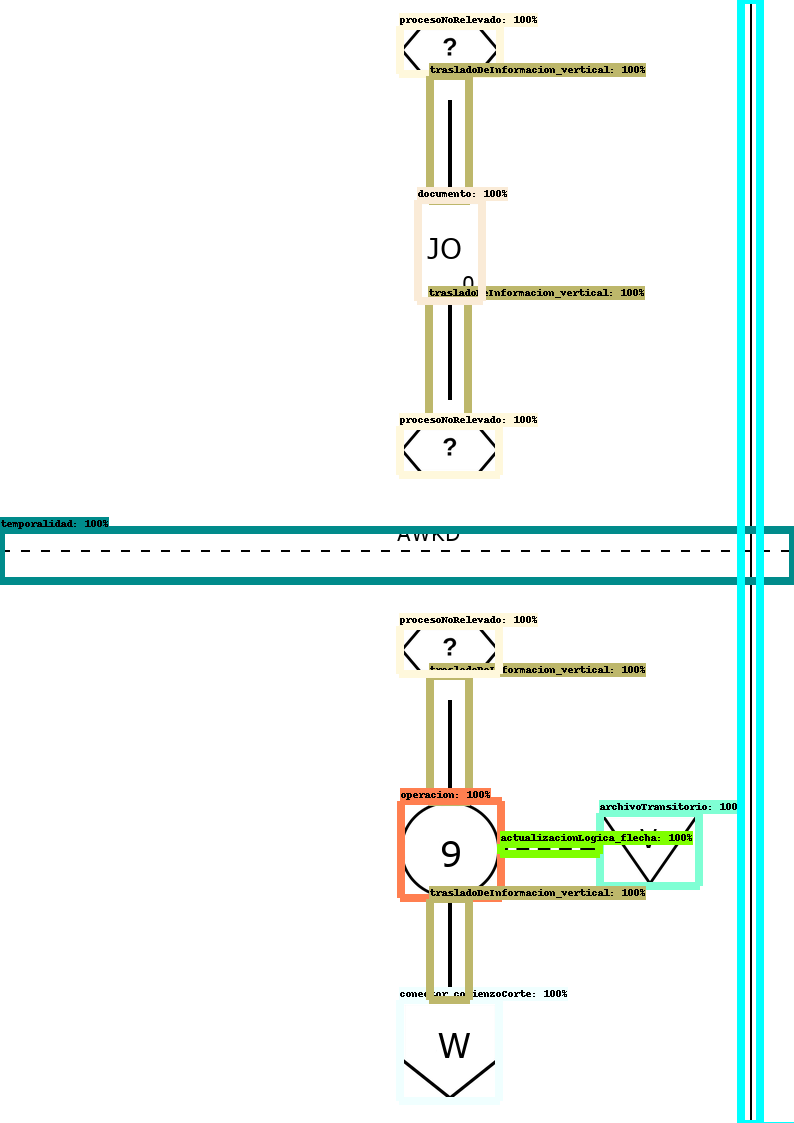



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_17.png : 

  tamaño de la imagen:  (1123, 794, 3) 



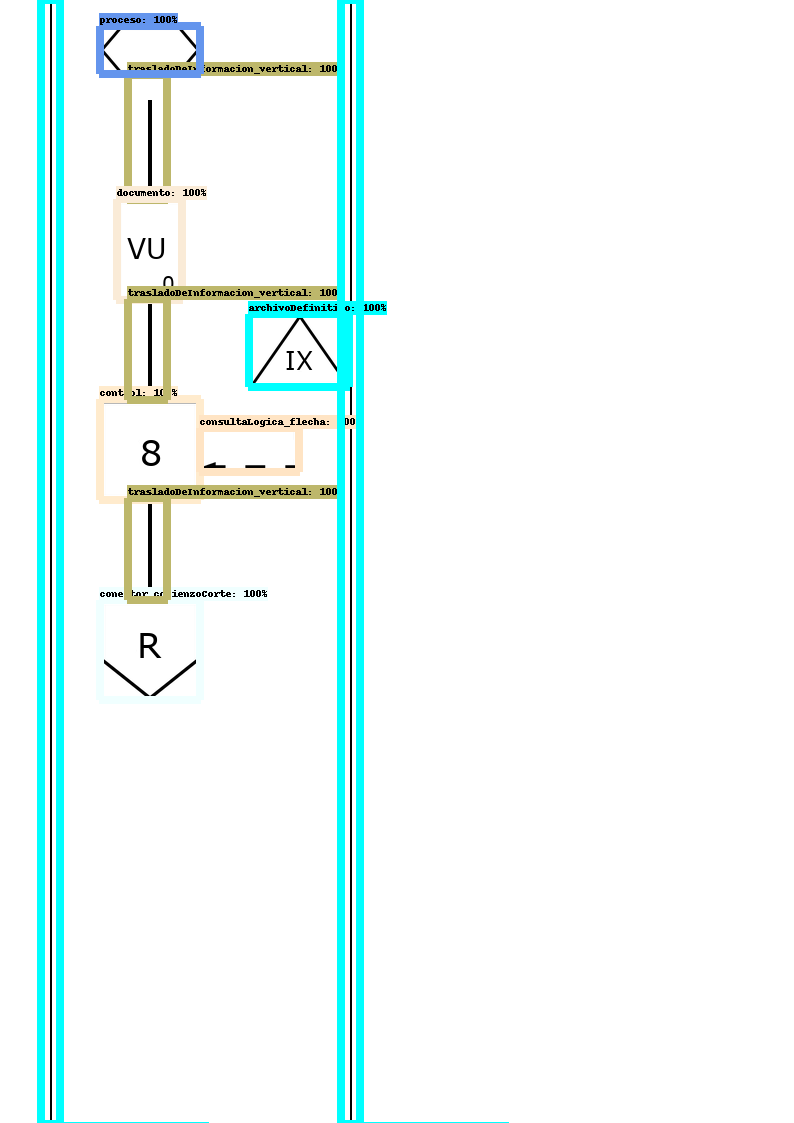



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_19.png : 

  tamaño de la imagen:  (1123, 794, 3) 



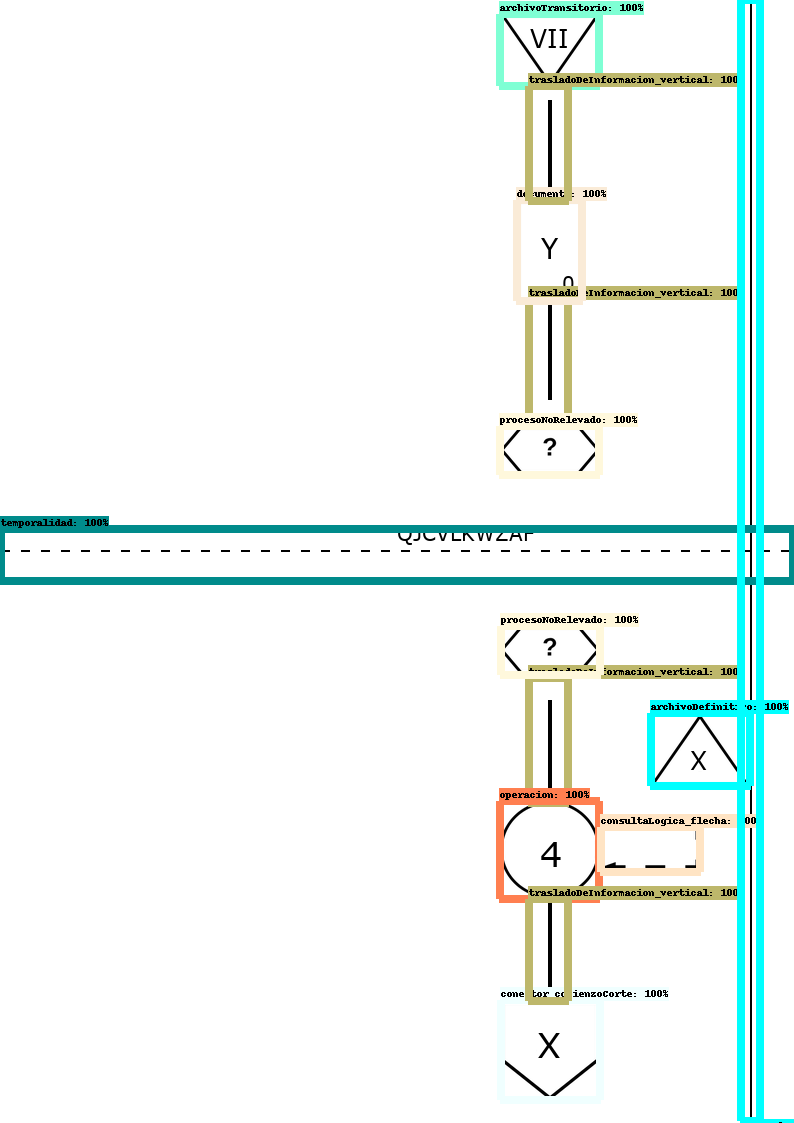



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_02.png : 

  tamaño de la imagen:  (1123, 794, 3) 



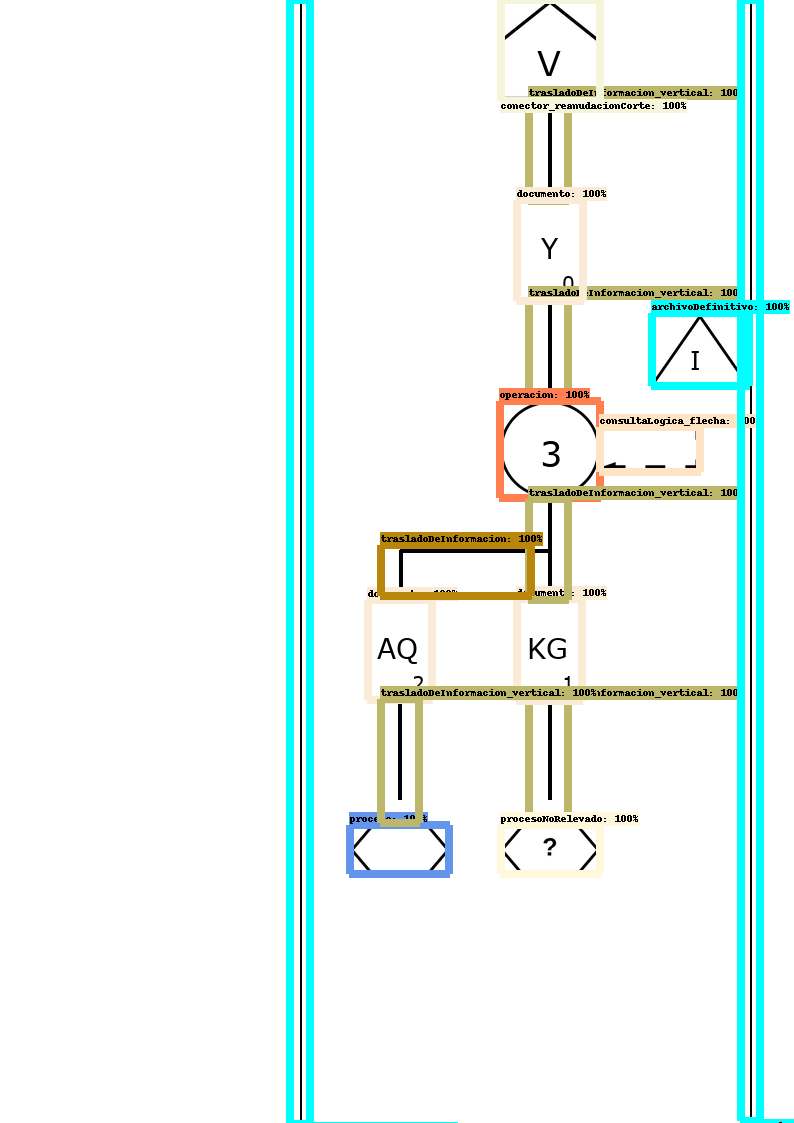



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_16.png : 

  tamaño de la imagen:  (1123, 794, 3) 



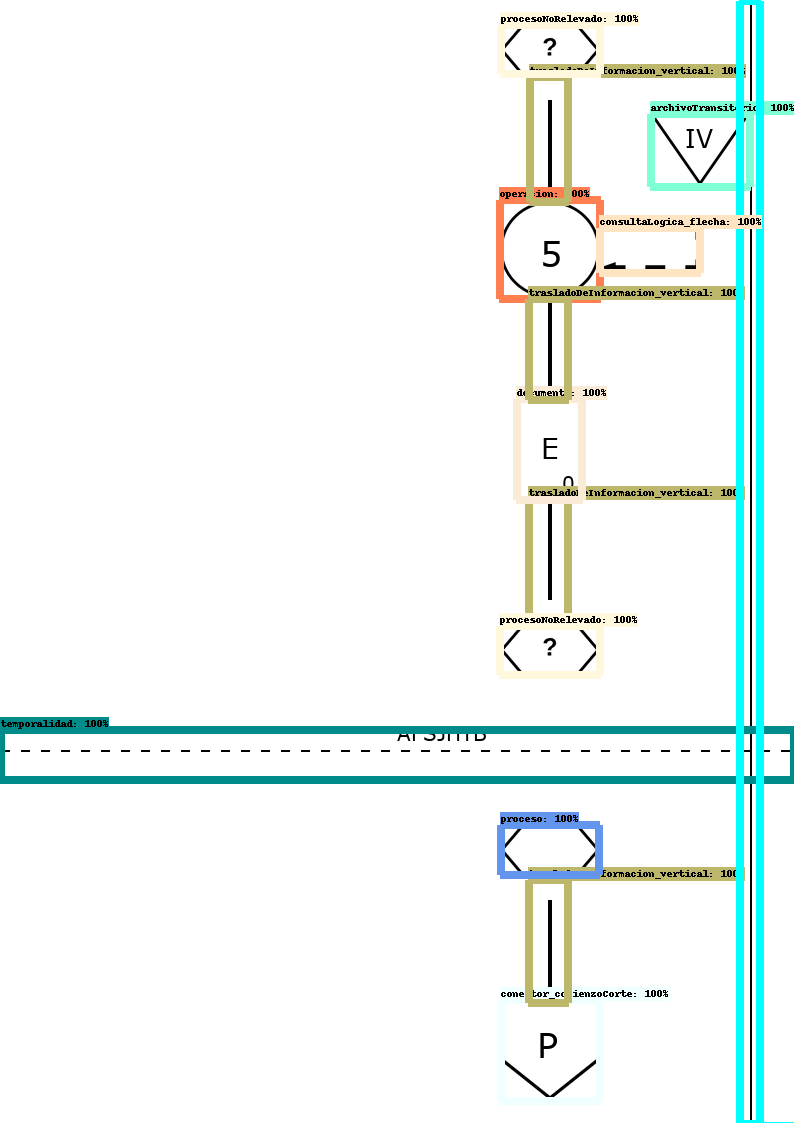



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_12.png : 

  tamaño de la imagen:  (1123, 794, 3) 



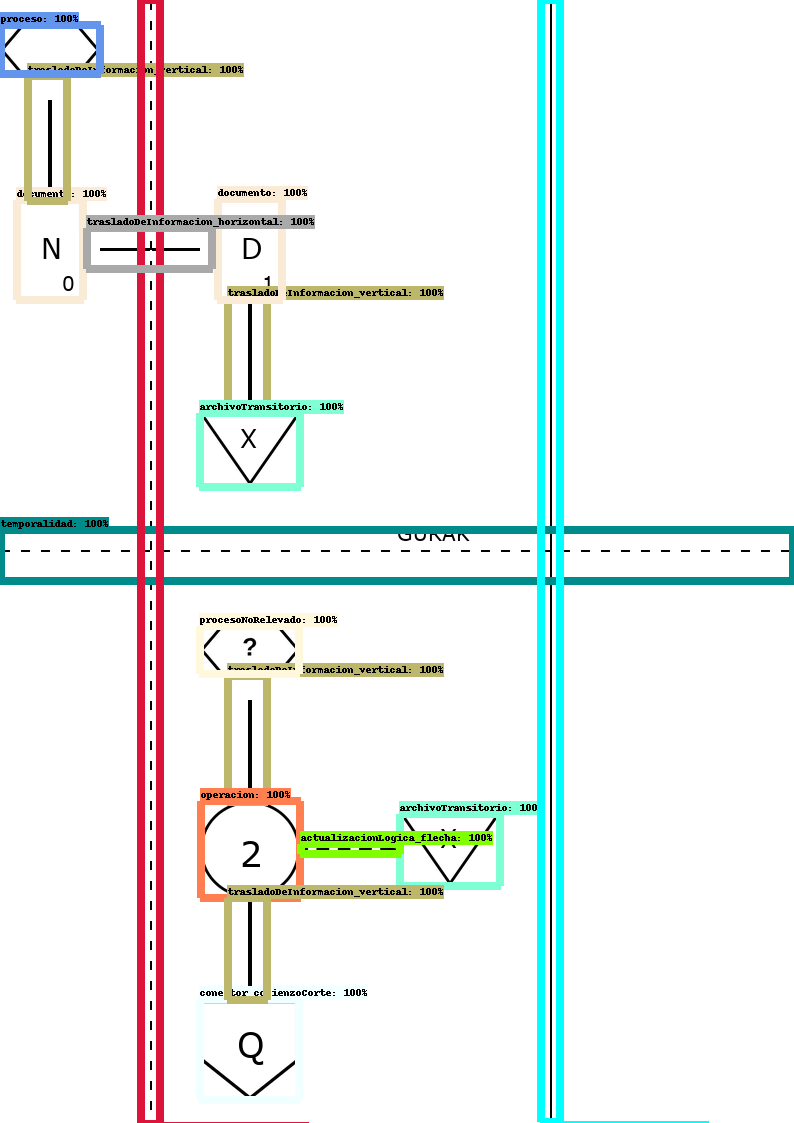



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_20.png : 

  tamaño de la imagen:  (1123, 794, 3) 



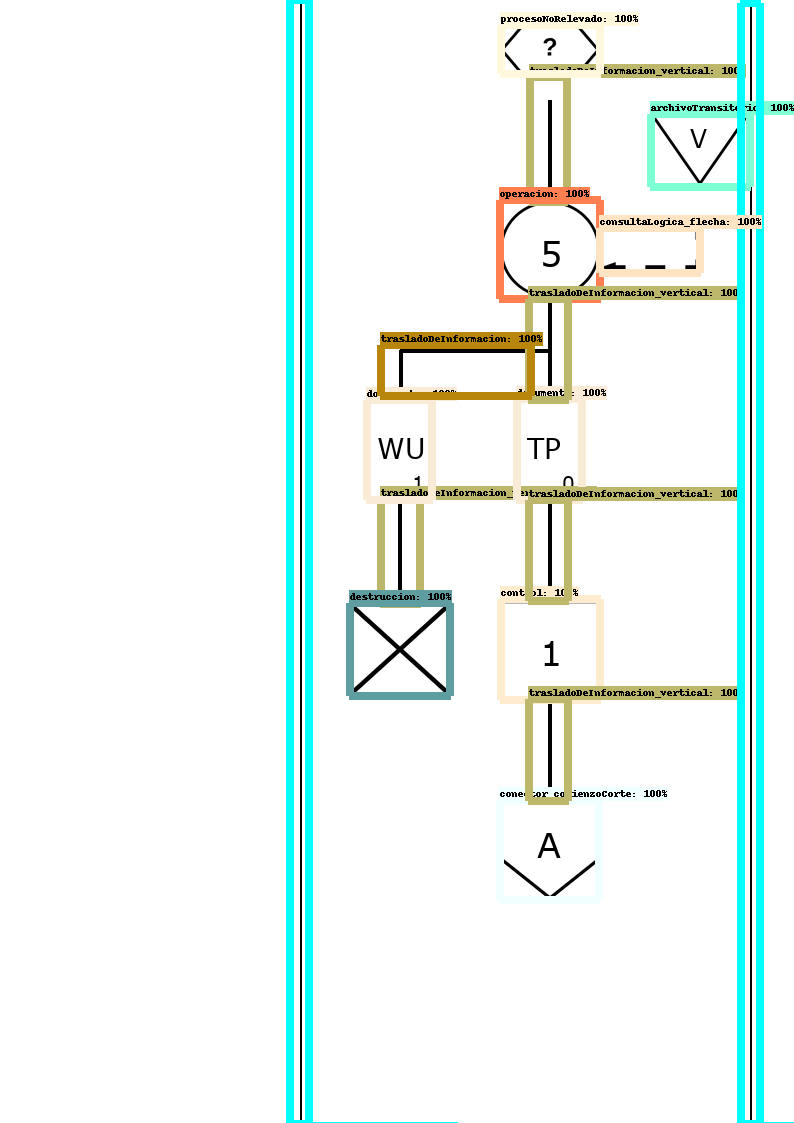



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_04.png : 

  tamaño de la imagen:  (1123, 794, 3) 



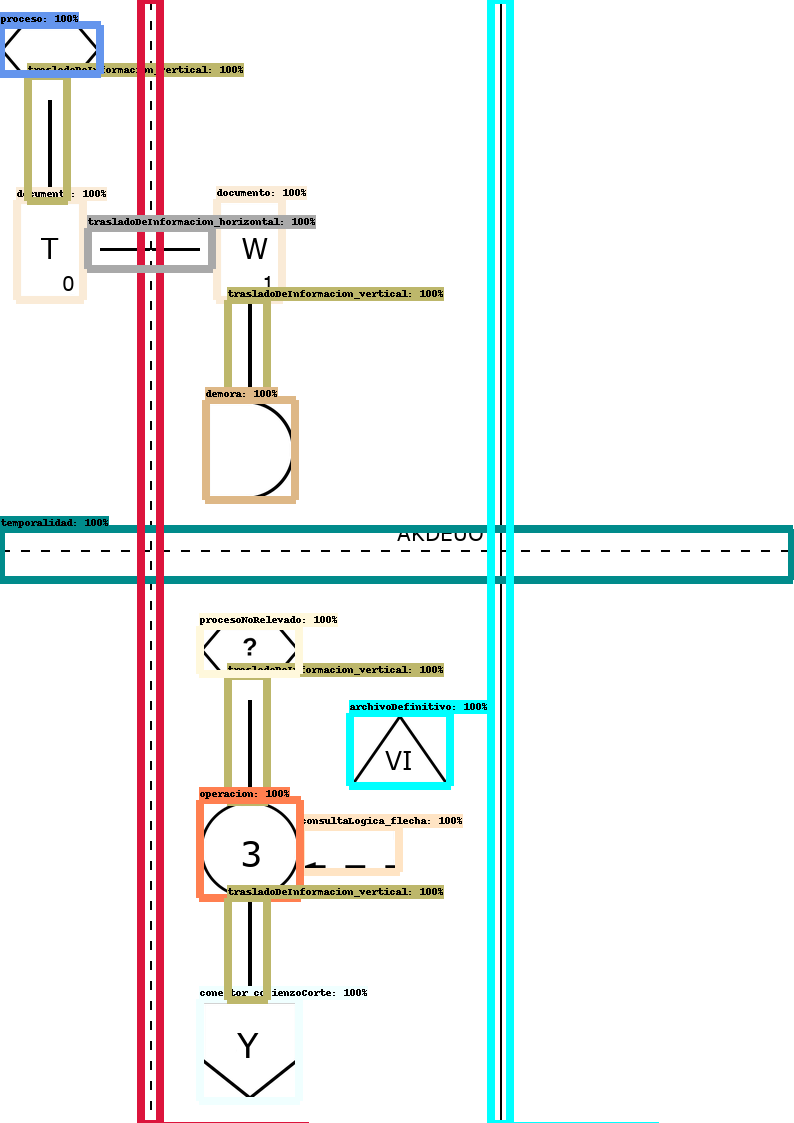



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_14.png : 

  tamaño de la imagen:  (1123, 794, 3) 



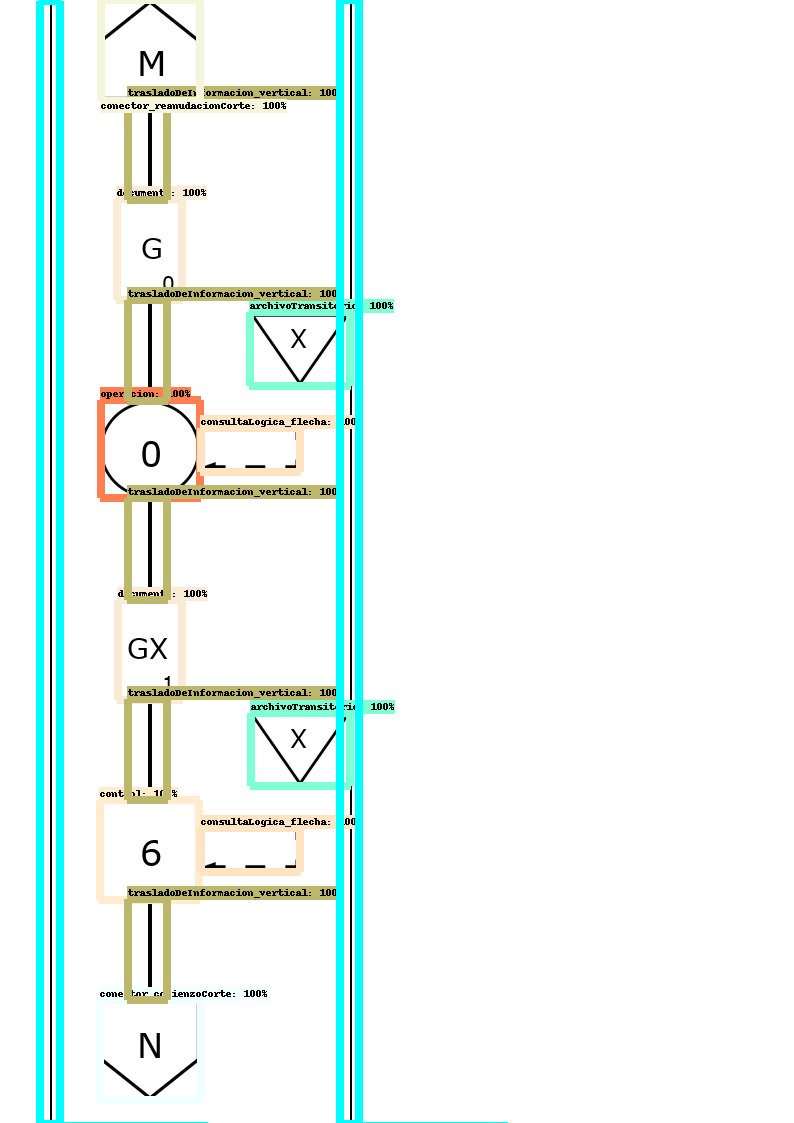



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_15.png : 

  tamaño de la imagen:  (1123, 794, 3) 



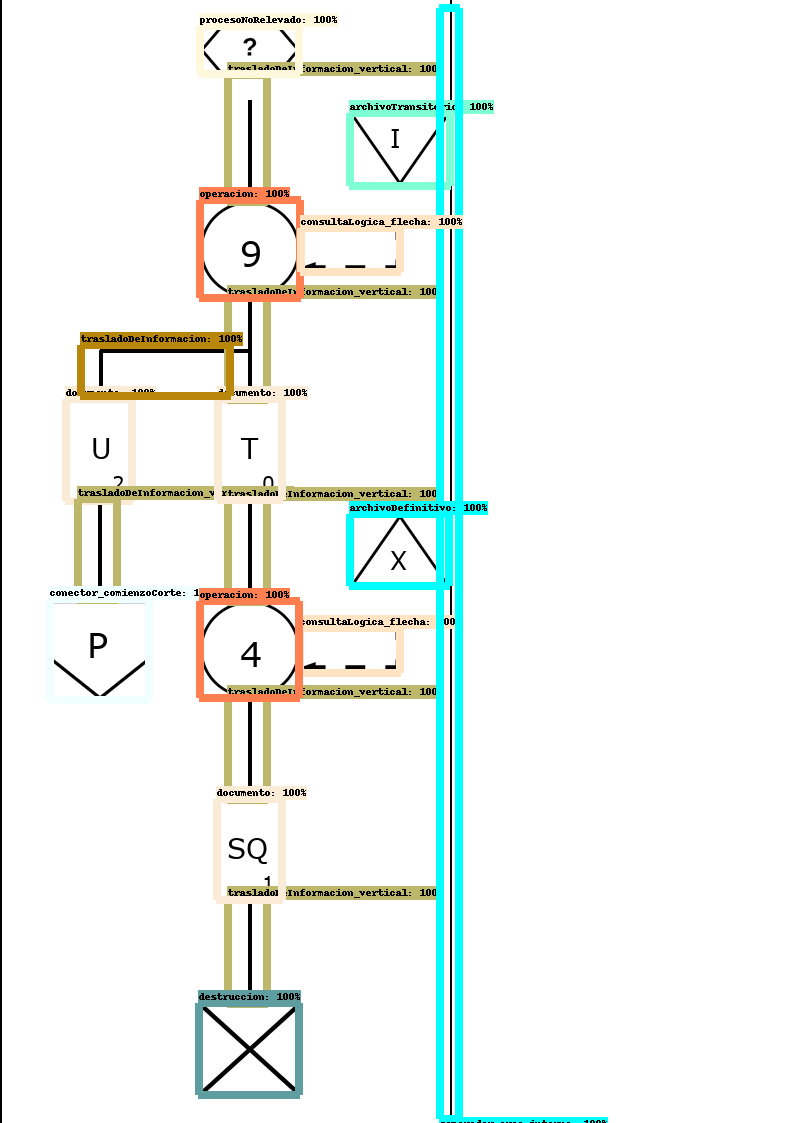



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_05.png : 

  tamaño de la imagen:  (1123, 794, 3) 



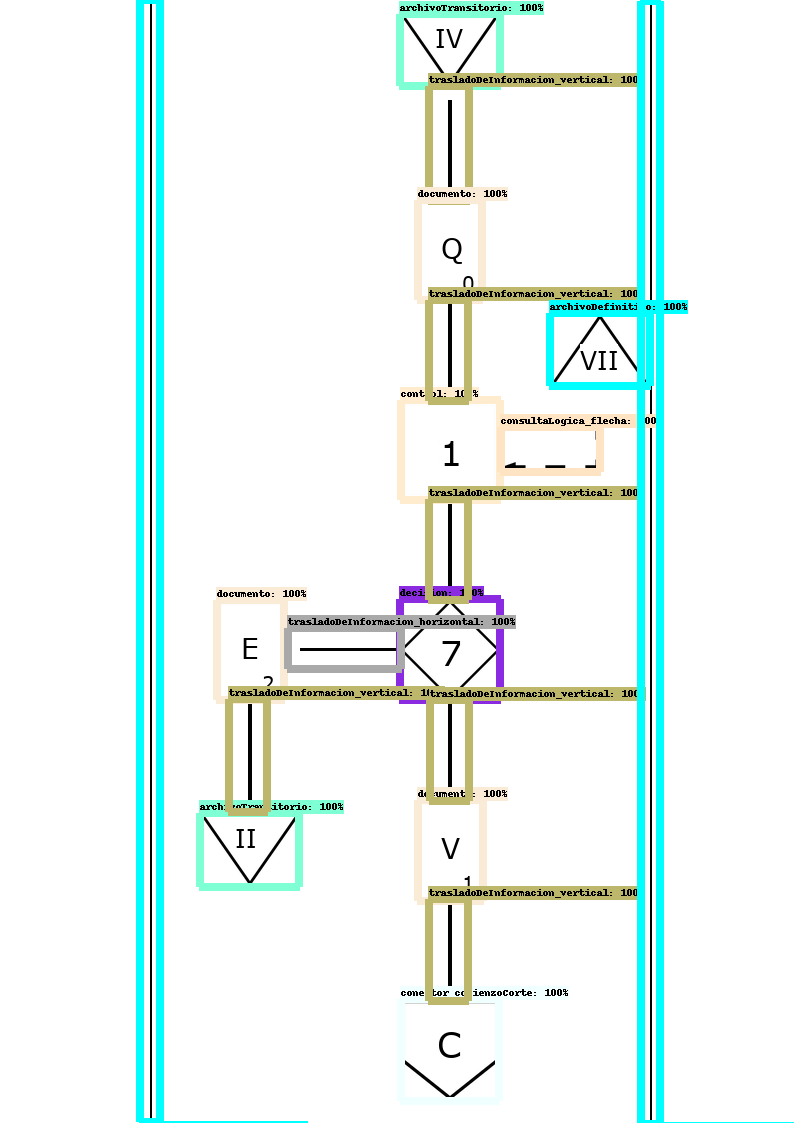



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_07.png : 

  tamaño de la imagen:  (1123, 794, 3) 



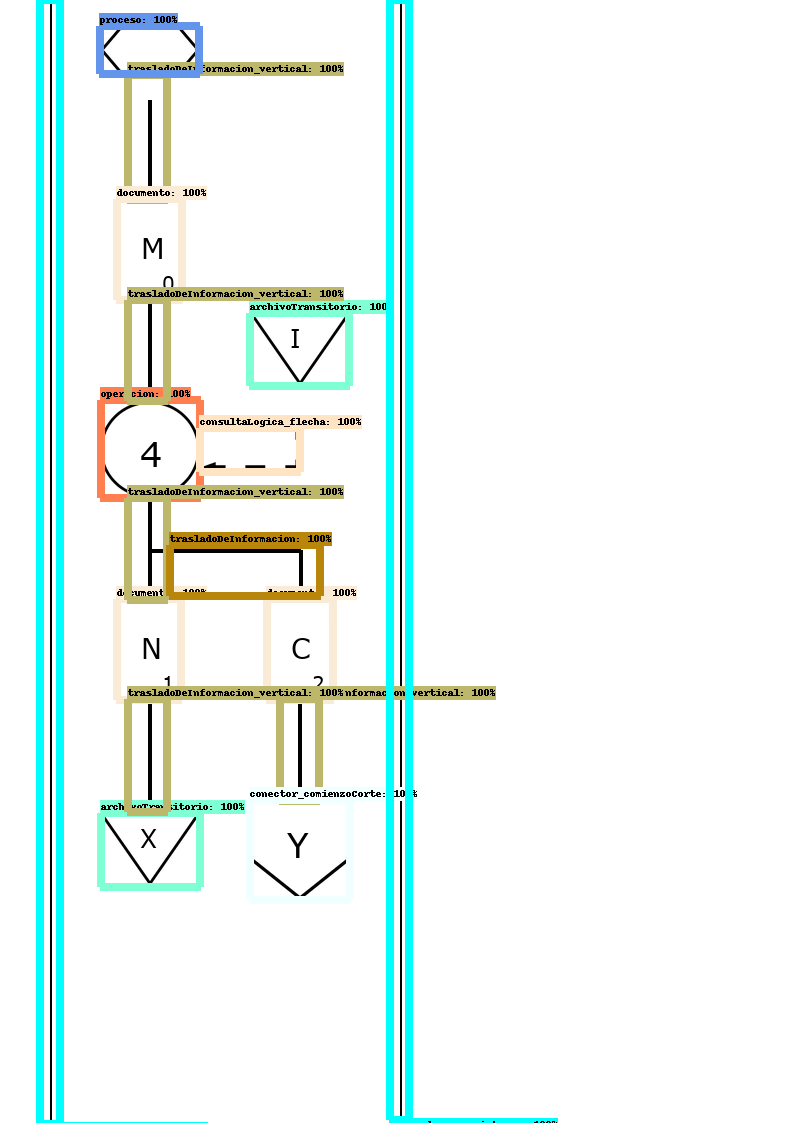



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_21.png : 

  tamaño de la imagen:  (1123, 794, 3) 



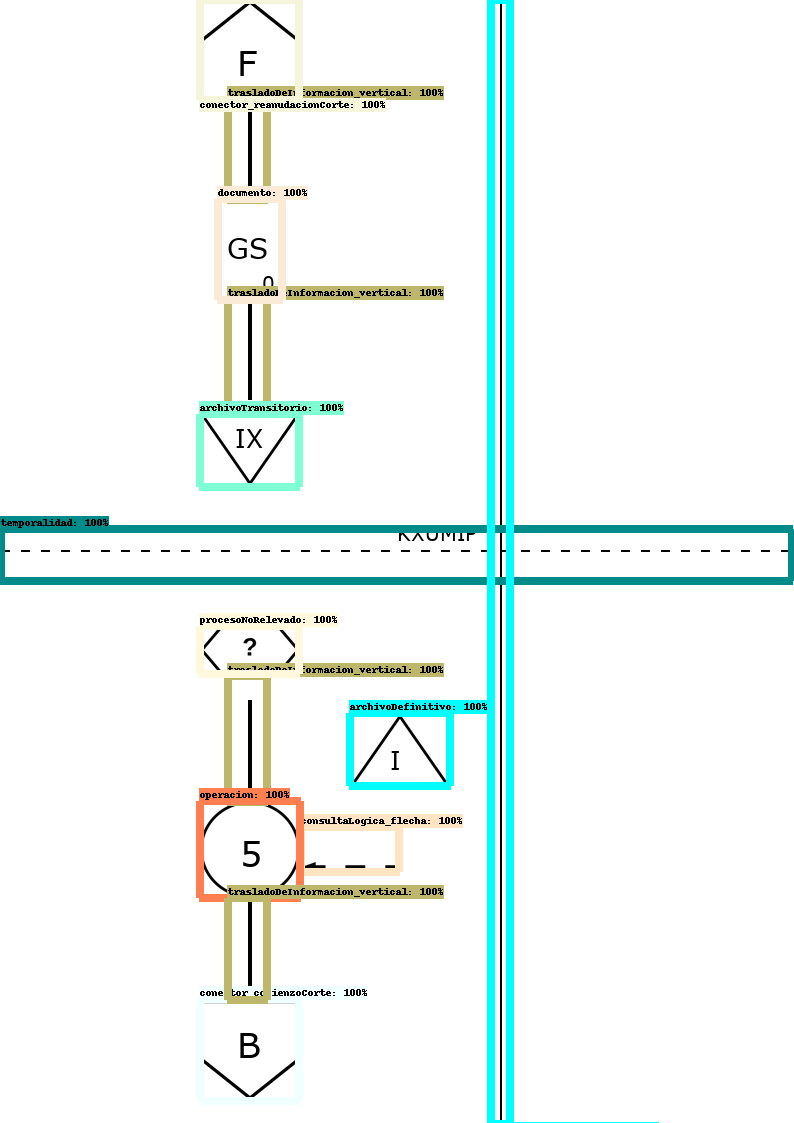



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_01.png : 

  tamaño de la imagen:  (1123, 794, 3) 



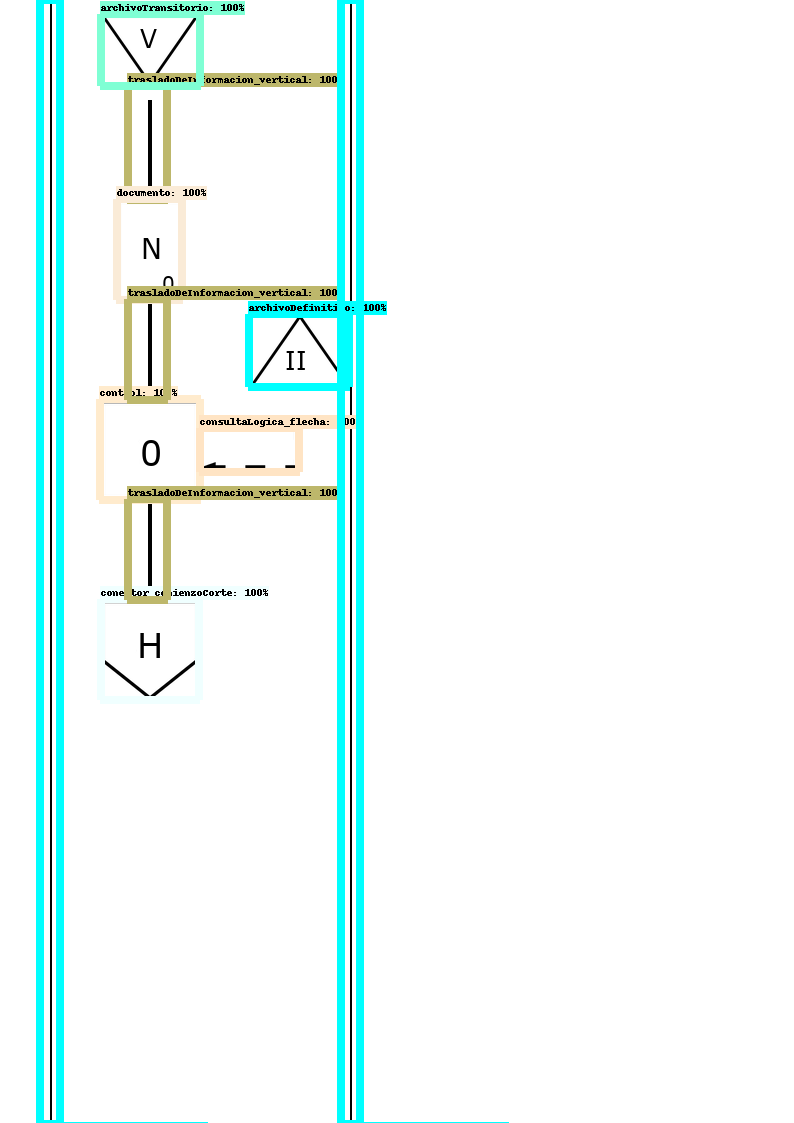



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_13.png : 

  tamaño de la imagen:  (1123, 794, 3) 



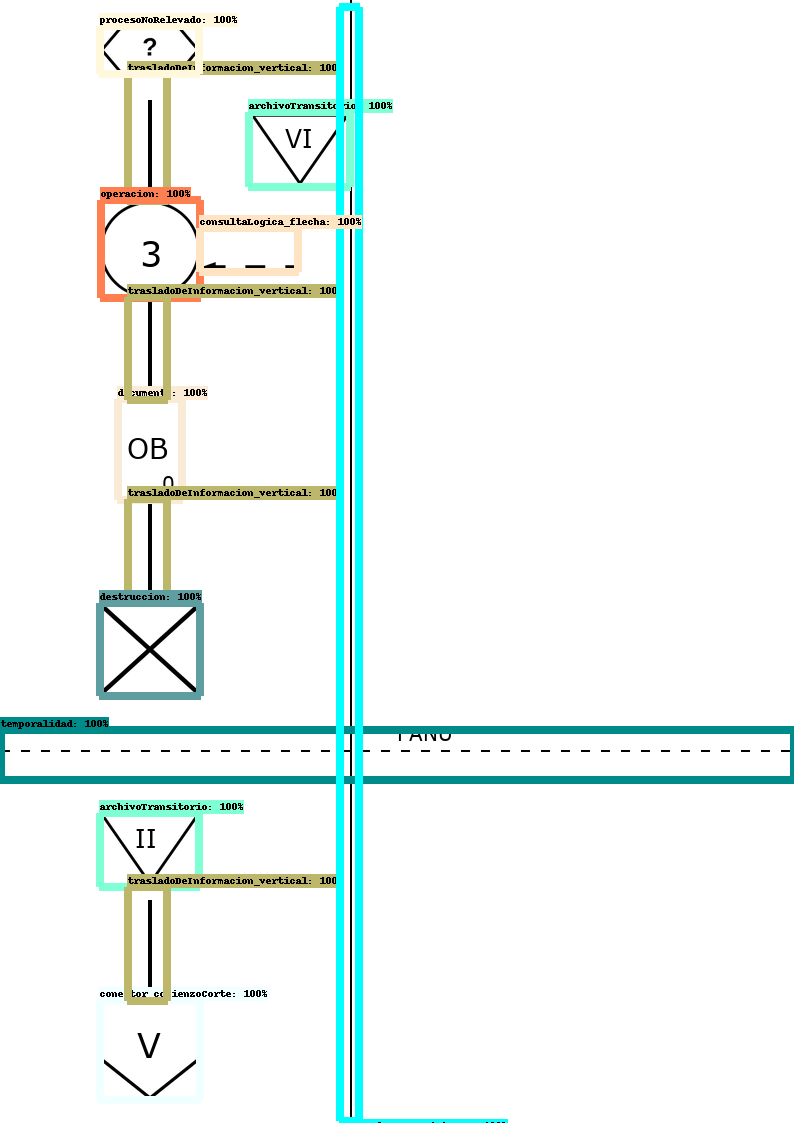



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_23.png : 

  tamaño de la imagen:  (1123, 794, 3) 



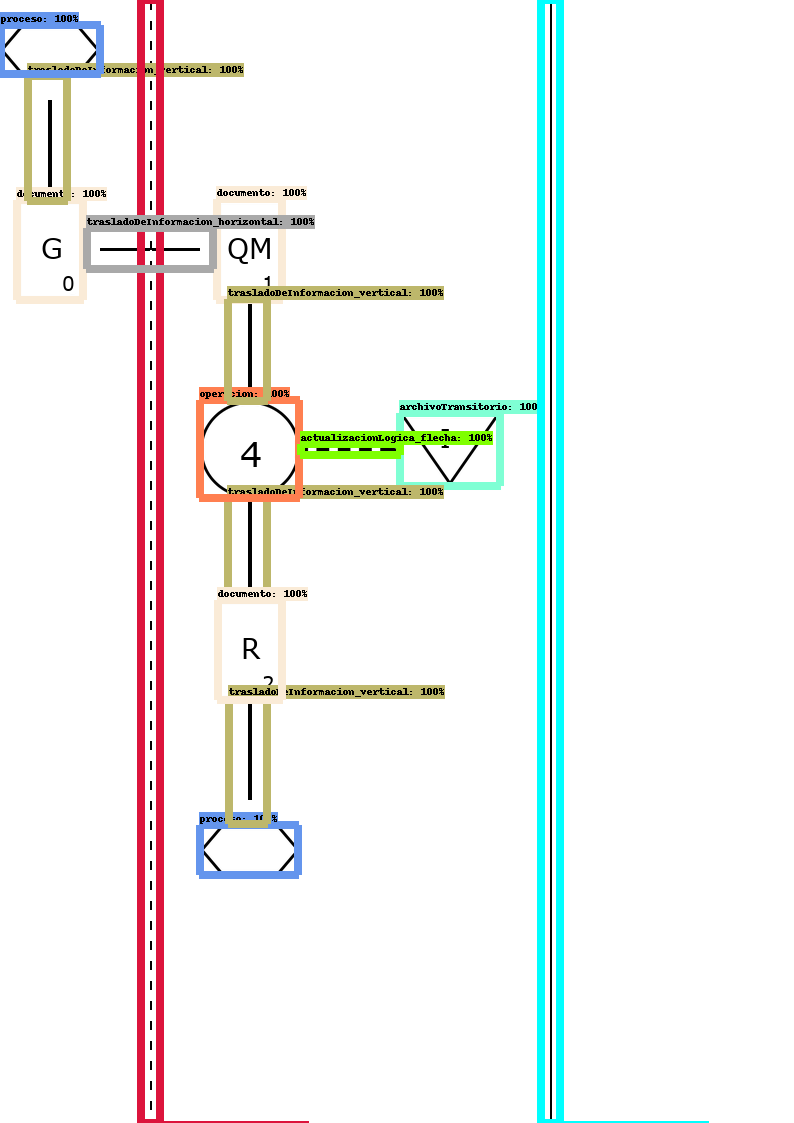



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_18.png : 

  tamaño de la imagen:  (1123, 794, 3) 



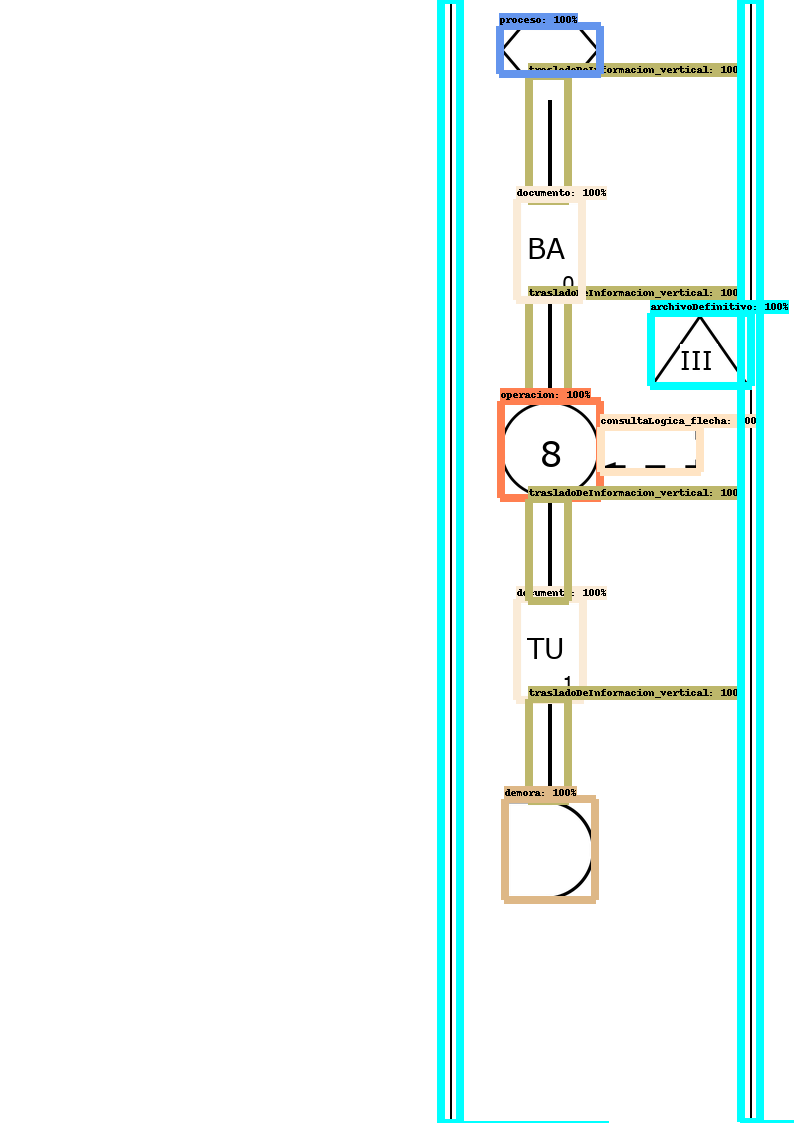



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_03.png : 

  tamaño de la imagen:  (1123, 794, 3) 



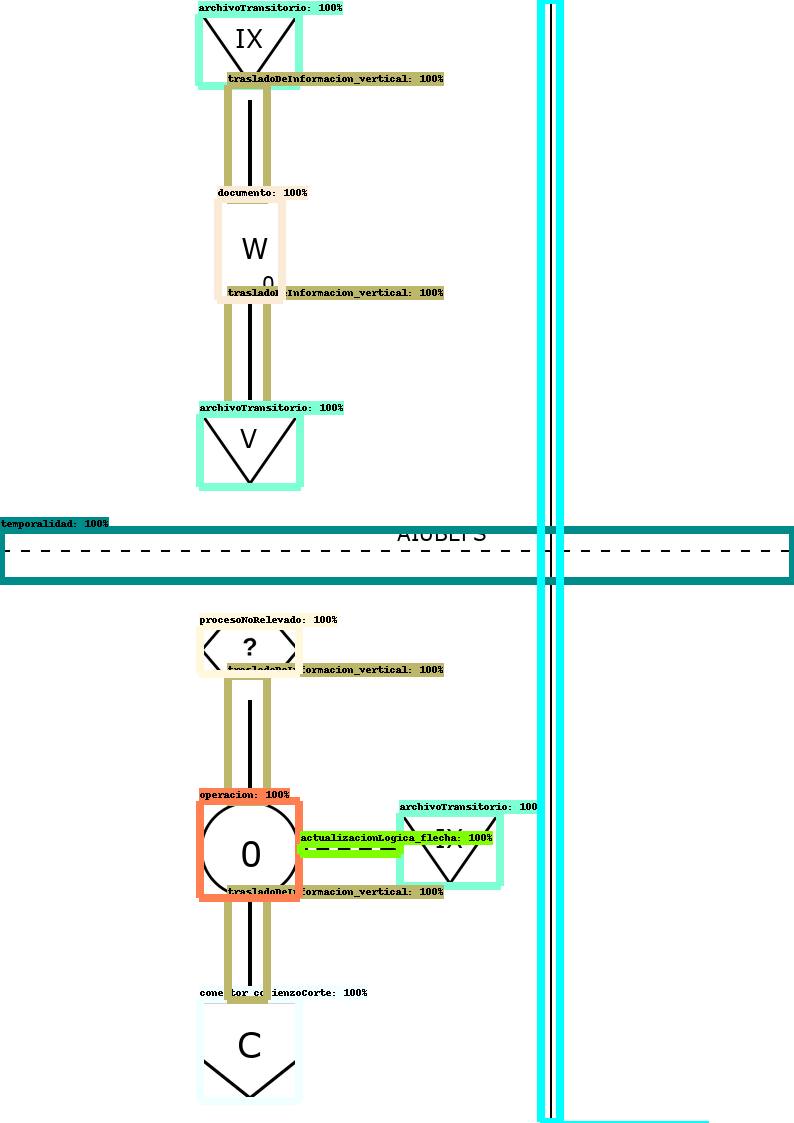



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_06.png : 

  tamaño de la imagen:  (1123, 794, 3) 



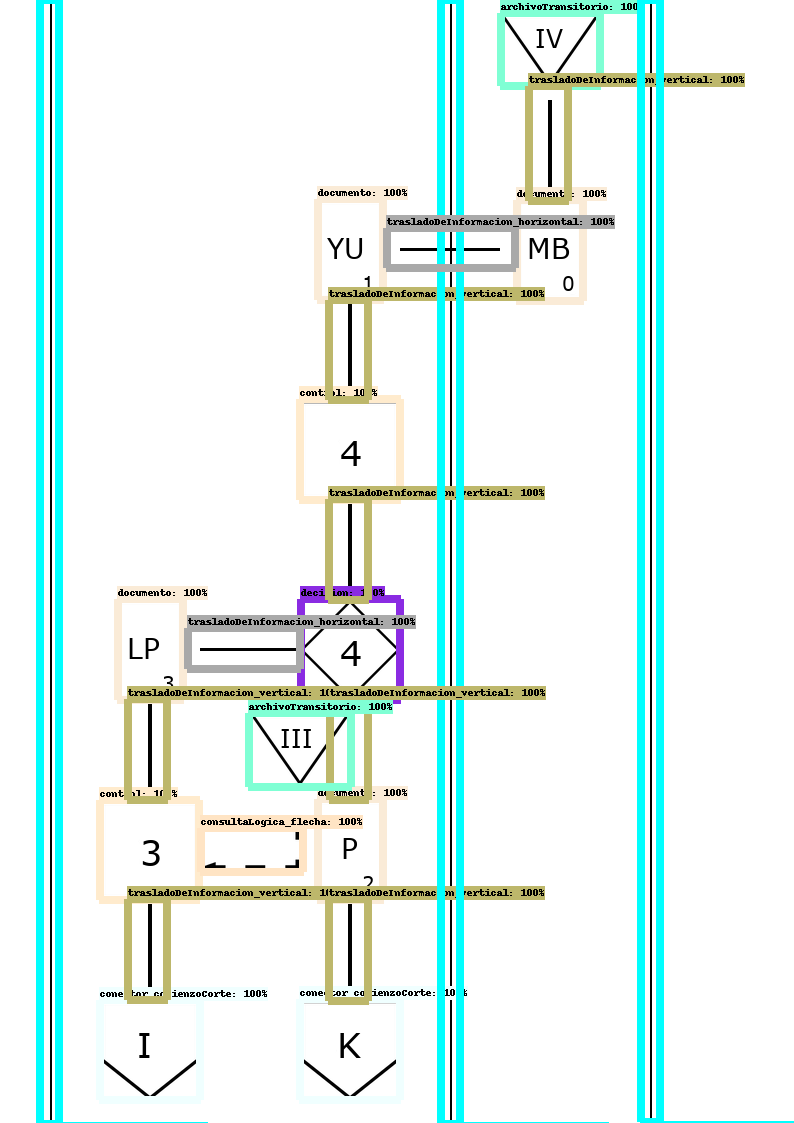



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/Para-Evaluar/curso_alumno_11.png : 

  tamaño de la imagen:  (1123, 794, 3) 



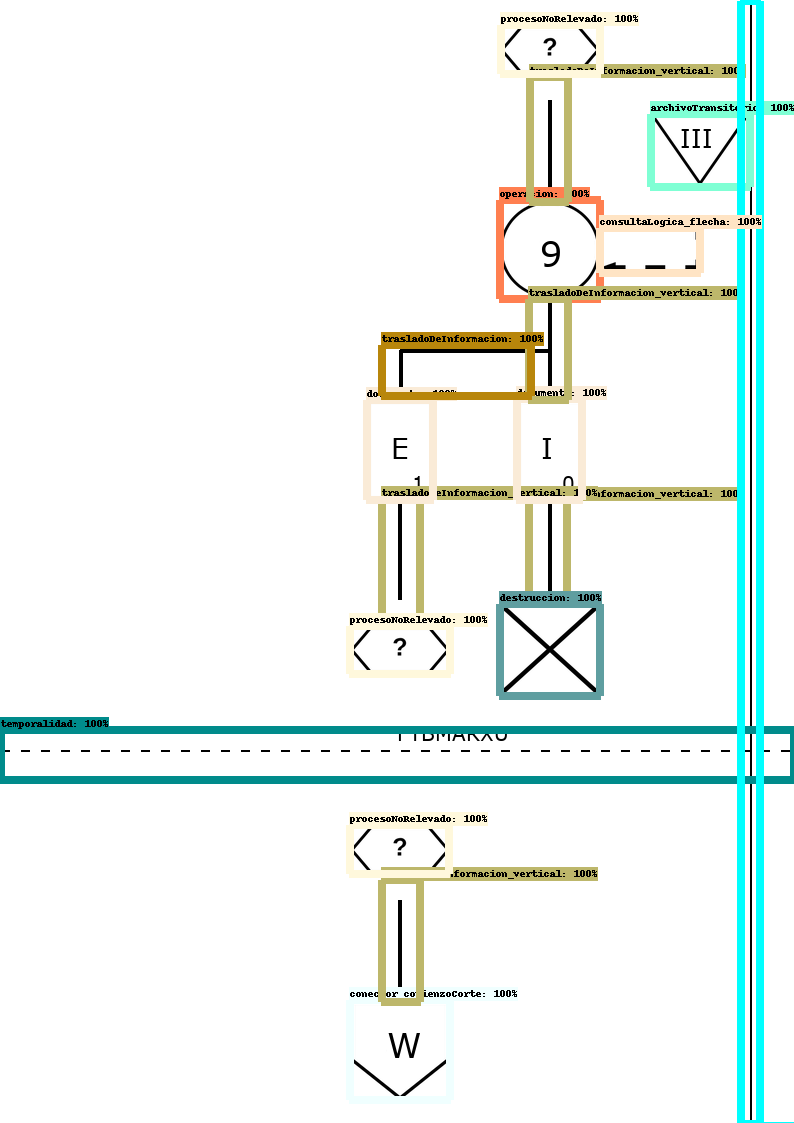

In [23]:
#@title Procesar imágenes para mostrar los objetos detectados por el modelo

# define minima probabilidad a usar
minimaProbabilidadObjectDetection = 90 #@param {type:"slider", min:1, max:100, step:1.0}
minProbObjDet = minimaProbabilidadObjectDetection / 100.0

# define si muestra detalle o no
muestraDetalleSubImagenes = False #@param {type:"boolean"}

# define si ejecuta OCR en sub-imagenes
EjecutaOCRenSubImagenes = False #@param {type:"boolean"}

muestraOCRSubImagenes = EjecutaOCRenSubImagenes

# procesa las imágenes 
for fn in process_FileNames:

  # define archivo a procesar y generar
  imagenProcesar = dirTest + '/' + fn

  print("\n\n> ", imagenProcesar, ": ")
  
  # open file to process
  imageCargada = ImPIL.open(imagenProcesar) 

  # Convierte la imagen a escala de grises y luego a RGB 
  # (para sacarle los colores que tuviera previamente y dejarlo con 3 canales de profundidad)
  imageCargada = imageCargada.convert('L')
  imageCargada = imageCargada.convert('RGB')

  # obtiene el tamaño de la imagen
  imCargada_ancho, imCargada_alto = imageCargada.size

  # convierte la imagen a un array 
  image_np = np.array(imageCargada)
  
  # Obtiene el tamaño de la imagen
  print("\n  tamaño de la imagen: ", image_np.shape, "\n")

  # Procesa el array de la imagen con el modelo cargado
  output_dict = run_inference_for_single_image(detection_model, image_np)

  # muestra los resultados
  plot_detections(
      image_np = image_np,
      boxes = output_dict['detection_boxes'],
      classes = output_dict['detection_classes'],
      scores = output_dict['detection_scores'],
      category_index = category_index,
      min_score = minProbObjDet)

  # muestra la imagen con los objetos detectados
  ##display( ImPIL.fromarray(image_np, 'RGB') )

  if muestraDetalleSubImagenes or muestraOCRSubImagenes:   

      # procesa los objetos detectados
      for detClass, detBox, detScore in zip(  output_dict['detection_classes'], output_dict['detection_boxes'], output_dict['detection_scores'] ):

        class_name = category_index[detClass]['name']

        # como las coordenadas están normalizadas las debe convertir 
        # teniendo en cuenta el tamaño de la imagen
        # además notar que vienen datas en otro orden
        # - detBox = (ini alto, ini ancho, fin alto, fin ancho)
        # - nuevoRangoIn = (ini ancho x1, ini alto y1, fin ancho x2, fin alto y2)    
        nuevoRangoIm = [detBox[1] * imCargada_ancho, 
                        detBox[0] * imCargada_alto,
                        detBox[3] * imCargada_ancho,
                        detBox[2] * imCargada_alto]

        # si el objeto detectado tiene un puntaje superior o igual al mínimo
        if detScore >= minProbObjDet:

            # calcula un valor para poder ordenar las figuras de arriba a abajo y izquierda a derecha
            centroideIm = nuevoRangoIm[1]*100000+nuevoRangoIm[0]

            # extrae la subimagen de acuerdo al área indicada por el detector        
            imDetObj = imageCargada.crop( nuevoRangoIm )
            imAncho, imAlto = imDetObj.size

            # muestra la sub-imagen
            print("\n")
            if muestraDetalleSubImagenes:              
              display( imDetObj )

            # muestra resultados
            print("    - detecta ", class_name, " : ", detScore*100, "% : ", detBox, "con centroide: ", centroideIm)

            # devuelve resultados del OCR
            if EjecutaOCRenSubImagenes:
              resOCR = hacerOCR(imageCargada, class_name, nuevoRangoIm)
              print("    * resOCR: ", resOCR)
        
        else:
              if detScore >= 0.4:
                print("-- objeto descartado por bajo score: ", class_name, "(", detScore*100, "%) en ", nuevoRangoIm)

